# Urban Sound Classification, Part 1
## Feature extraction from sound

Author: David Salvo Gutiérrez

### Introduction
We all got exposed to different sounds every day. Like, the sound of traffic jam, siren, music and dog bark etc. We understand sound in terms of recognition and association to a known sound, but what happens when you don't know that sound and not recognize his source?

Well that's the same starting point for a computer classifier. In that sense, how about teaching computer to classify such sounds automatically into different categories.

In this notebook we will learn techniques to classify urban sound using machine learnig. Classifying sound is pretty different from other source of data. In this notebook we will first see what features can be extracted from sound data and how easy it is to extract such features in Python using open source library called [*Librosa*](http://librosa.github.io/).

To follow this tutorial, make sure you have installed the following tools:
* Tensorflow
* Librosa
* Numpy
* Matplotlib
* glob
* os
* keras
* pandas
* scikit-learn
* datetime

### Dataset

In this experience we are focused on delvelop a convolutional neural network model able to classify automatically the different urban sounds. To train and work afford this project, I use the urban sound dataset UbanSound8K published by the SONY project reserchers. It contains 8.732 labelled sound clips (<= 4s) from ten different classes according their Urban Soun Taxonomy publication:

* Aire Conditioner (classID = 0)
* Car Horn (classID = 1)
* Children Playing (classID = 2)
* Dog Bark (classID = 3)
* Drilling (classID = 4)
* Engine Idling (classID = 5)
* Gun Shot (classID = 6)
* Jackhammer (classID = 7)
* Siren (classID = 8)
* Street Music (classID = 9)

This dataset is available for free in this link, [*UrbanSound8K*](https://urbansounddataset.weebly.com/urbansound8k.html).

Whe you download the dataset, you will get a '.tar.gz' compressed file (UNIX compression distribution), from Windows you can use prgrams like 7-zip to uncompress the file.

That file contains two different directories, one of them you can find information about audio fragments classification from a metadata 'UrbanSound8K.csv' file. The other directory contains the audio segments divided in 10 different blocks not classified by classes. Finally, audio data is distibuted as:

* slice_file_name: The name of the audio file. The name takes the following format: fsID-classID-occurrenceID-sliceID.wav
* fsID: the Freesound ID of the recording from which this excerpt (slice) is taken
* start: The start time of the slice in the original Freesound recording
* end: The end time of slice in the original Freesound recording
* salience: A (subjective) salience rating of the sound. 1 = foreground, 2 = background.
* fold: The fold number (1-10) to which this file has been allocated.
* classID: A numeric identifier of the sound class
* class: The class name

source:
J. Salamon, C. Jacoby and J. P. Bello, "A Dataset and Taxonomy for Urban Sound Research", 
22nd ACM International Conference on Multimedia, Orlando USA, Nov. 2014.

### Featuring Sound
In this dataset, the sound files are in .wav format bt if you have files in another format such as .mp3, then it's recommended to convert them into .wav format. It's beacuse .mp3 is lossy music compressino technique. To keep thins simple, we will use sound files form only first three folds, namely fold1, fold2 and fold3.

Let's read some sound files and visualise to understand how different each sound clip is from other. Matplotlib's specgram method performs all the required calculation and plotting of the spectrum. Likewis, Librosa provide handy method for wave and log power spectrogram plotting. By looking at the plots we can see apparent differences between sound clips of different classes.

## UrbanSound8K searcher dataset
Use this panda module code to navegate and work with UrbanSound8K dataset, usign its .csv provided file wich contains all audio dataset information.

In [1]:
import pandas as pd
pd.__version__

urban_sound = pd.read_csv("metadata/UrbanSound8K.csv", sep=",")
urban_sound.describe()

,fsID,start,end,salience,fold,classID
count,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000
mean,116033.493816,38.645409,42.253312,1.347000,5.385937,4.592877
std,57991.017218,74.292126,74.369669,0.476043,2.846820,2.894544
min,344.000000,0.000000,0.105962,1.000000,1.000000,0.000000
25%,69942.250000,3.000000,6.839398,1.000000,3.000000,2.000000
50%,118279.000000,10.376492,14.000000,1.000000,5.000000,4.000000
75%,166942.000000,35.131372,38.866979,2.000000,8.000000,7.000000
max,209992.000000,600.125356,604.125356,2.000000,10.000000,9.000000


In [8]:
urban_sound.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [9]:
# introduce the slice_file_name you want to analyze on the dataset in this variable:

audio_file_name = ["57320-0-0-7.wav","24074-1-0-3.wav","15564-2-0-1.wav","31323-3-0-1.wav",
"46669-4-0-35.wav","89948-5-0-0.wav","40722-8-0-4.wav",
"103074-7-3-2.wav","106905-8-0-0.wav","108041-9-0-4.wav"]

data = pd.read_csv("metadata/UrbanSound8K.csv", sep=",", index_col="slice_file_name")

founded = data.loc[audio_file_name]
founded

,fsID,start,end,salience,fold,classID,class
slice_file_name,,,,,,,
57320-0-0-7.wav,57320,3.500000,7.500000,2,1,0,air_conditioner
24074-1-0-3.wav,24074,14.560993,18.560993,1,1,1,car_horn
15564-2-0-1.wav,15564,0.500000,4.500000,1,1,2,children_playing
31323-3-0-1.wav,31323,0.992016,4.992016,2,1,3,dog_bark
46669-4-0-35.wav,46669,17.500000,21.500000,1,1,4,drilling
89948-5-0-0.wav,89948,6.675761,10.675761,1,1,5,engine_idling
40722-8-0-4.wav,40722,2.000000,6.000000,2,1,8,siren
103074-7-3-2.wav,103074,47.632637,51.632637,1,1,7,jackhammer
106905-8-0-0.wav,106905,43.636489,47.636489,2,1,8,siren


### Pakage to be used
We’ll be using librosa for analyzing and extracting features of an audio signal. For playing audio we will use pyAudio so that we can play music on jupyter directly.

#### Librosa
LibROSA is a python package for music and audio analysis. It provides the building blocks necessary to create music information retrieval systems.

**librosa.load():** loads and decodes the audio as a time series 'x', represented as a one-dimensional NumPy floating point array. The variable 'sr' contains the sampling rate of 'x', that is the number of samples per second of audio. By default all audio is mixed to mono and resampled to 22050 Hz at load time. This behavior can be overridden by supplying additional arguments to 'librosa.load()'.

In [11]:
import librosa
import numpy as np
#audio_path = '../train/57320-0-0-7.wav' # air_conditioner
#audio_path = '../train/24074-1-0-3.wav' # car_horn 
#audio_path = '../train/15564-2-0-1.wav' # children_playing
# audio_path = 'audio/fold1/31323-3-0-1.wav' # dog_bark
#audio_path = '../train/46669-4-0-35.wav' # drilling
#audio_path = '../train/89948-5-0-0.wav' # engine_idling
#audio_path = '../train/102305-6-0-0.wav' # gun_shot
#audio_path = '../train/103074-7-3-2.wav' # jackhammer
# audio_path = 'audio/fold1/106905-8-0-0.wav' # siren
# audio_path = 'train/fold1/7383-3-0-0.wav' # siren
audio_path = 'train/street_music/171406-9-0-124.wav' # street_music
x , sr = librosa.load(audio_path) # Carga las muestras digitales de audio
print(type(x), type(sr))
print(x.size)

<class 'numpy.ndarray'> <class 'int'>
88200


In [12]:
print(x.size)
print(max(x))
print(min(x))
print(sr)

88200
0.03771301
-0.039302155
22050


### Playing an audio
IPython.display allow us to play audio on jupyter notebook directly. It has a very simple interface with some basic buttons.

In [13]:
import IPython.display as ipd
ipd.Audio(audio_path)

22050


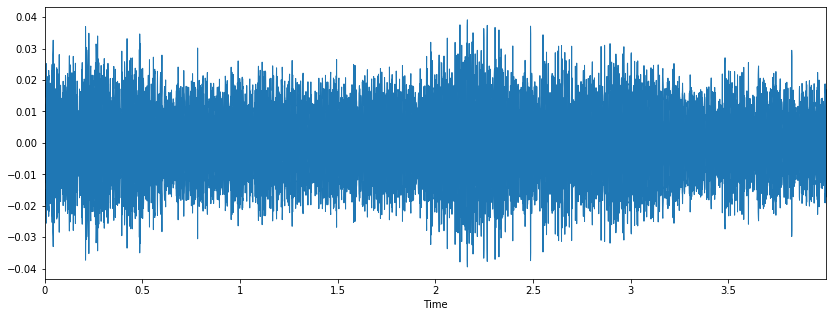

In [14]:
# display waveform
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
print(sr)

librosa.display is used to display the audio files in different formats such as wave plot, spectrogram, or colormap.

* **Waveplots let us know the loudness of the audio at a given time.** 
* **Spectogram** shows different frequencies playing at a particular time along with it’s amplitude. 

Amplitude and frequency are important parameters of the sound and are unique for each audio. librosa.display.waveplot is used to plot waveform of amplitude vs time where the first axis is an amplitude and second axis is time.

### Spectogram
A spectogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It's a representation of frequencies changing with respect to time for given music signals.

(1025, 173)


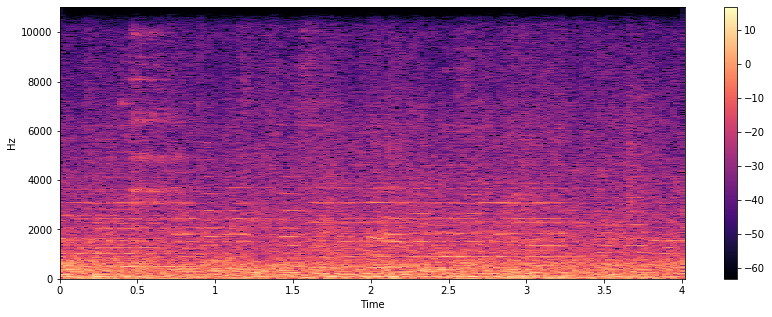

In [15]:
# display Spectrogram
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14,5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

print(X.shape)
#If to print log of frequencies
# librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

***.stft*** converts data into short term Fourier transform. [*STFT*](https://www.youtube.com/watch?v=g1_wcbGUcDY) converts signal such that we can know the amplitude of given frequency at a given time. Using STFT we can determine the amplitude of various frequencies playing at a given time of an audio signal. ***.specshow*** is used to display spectrogram.

### MFCC - Mel-Frequency Cepstral Coefficients

This feature is one of the most important method to extract a feature of an audio signal and is used majorly whenever working on audio signals. The mel frequency cepstral coefficents (MFCCs) of signal are a small set of features (usually about 10-20) which concisely describe the overall shape of a spectral envelope.

(20, 173)


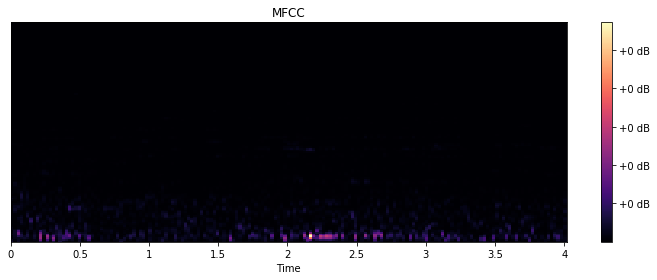

In [25]:
mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)

# Displaying the MFCCs:
plt.figure(figsize=(10, 4))
librosa.display.specshow(S, sr=sr, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [16]:
# Displaying the MFCCs:

D = librosa.amplitude_to_db(mfccs, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.tight_layout()
plt.show()

NameError: name 'mfccs' is not defined

***.mfcc*** is used to calculate mfccs of a signal.
By printing the shape of mfccs you get how many mfccs are calculated on how many frames. The first value represents the number of mfccs calculated and another value represents a number of frames available.

**Ml-Spectrogram**
Compute a mel-scaled spectrogram.

If a spectrogram input S is provided, then it is mapped directly onto the mel basis mel_f by mel_f.dot(S).

If a time-series input y, sr is provided, then its magnitude spectrogram S is first computed, and then mapped onto the mel scale by mel_f.dot(S**power). By default, power=2 operates on a power spectrum.

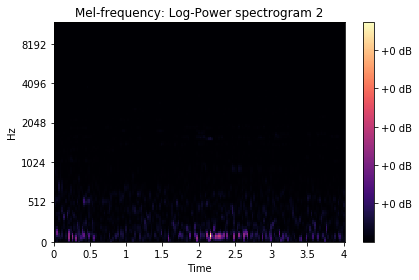

<class 'numpy.ndarray'>
(128, 173)
<class 'numpy.ndarray'>
(128, 346)
[[-10.0423727  -21.38755035 -11.8532095  ...   0.           0.
    0.        ]
 [-11.96800423 -16.24470901 -12.6015873  ...   0.           0.
    0.        ]
 [-18.48330688 -13.42007446 -12.51041603 ...   0.           0.
    0.        ]
 [-18.03174782 -12.47302914  -8.36844921 ...   0.           0.
    0.        ]
 [-13.54751396 -11.86274147  -5.09497356 ...   0.           0.
    0.        ]]


In [23]:
# Using a pre-computed power spectrogram would give the same result:

# D = np.abs(librosa.stft(x))

# Passing through arguments to the Mel filters

S = librosa.feature.melspectrogram(x, sr=sr, win_length=512, n_mels=128)
# S2 = librosa.feature.melspectrogram(x, sr=sr, n_mels=128)

# plt.figure(figsize=(10, 4))
# librosa.display.specshow(D, sr=sr, y_axis='log', x_axis='time')
# plt.colorbar(format='%+2.0f')
# plt.title('Power spectrogram 1')
# plt.tight_layout()
# plt.show()



# plt.figure(figsize=(10, 4))
# librosa.display.specshow(S, sr=sr, y_axis='log', x_axis='time')
# plt.colorbar(format='%+2.0f')
# plt.title('Power spectrogram 2')
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(10, 4))
# librosa.display.specshow(librosa.power_to_db(D**2, ref=np.max), sr=sr, y_axis='log', x_axis='time')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Mel-frequency: Log-Power spectrogram 1')
# plt.tight_layout()

# melspec = librosa.feature.melspectrogram(x, sr=sr, win_length=512, n_mels = 128) #revisar n_mels a 128
# logspec = librosa.power_to_db(melspec, ref=np.max)
# print(logspec.shape)


# plt.figure(figsize=(10, 4))
# S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S, x_axis='time', y_axis='mel', sr=sr, fmax=12000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency: Log-Power spectrogram 2')
plt.tight_layout()
plt.show()

print(type(S_dB))
print(S_dB.shape)

features = np.concatenate((S_dB, np.zeros(np.shape(S_dB))), axis = 1)

print(type(features))
print(features.shape)
print(features[:5])

# plt.figure(figsize=(10, 4))
# S2_dB = librosa.power_to_db(S2, ref=np.max)
# librosa.display.specshow(S2_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
# plt.colorbar(format='%+2.0f dB')
# plt.title('Mel-frequency: Log-Power spectrogram 2')
# plt.tight_layout()
# plt.show()

In [14]:
dog = 'train/fold1/7383-3-0-0.wav' # perro
gun = 'train/fold1/7061-6-0-0.wav'
drilling = 'train/fold1/195063-4-0-0.wav'
#audio_path = '../train/108041-9-0-4.wav' # street_music

bands = 128
frames = 128

window_size = 512 * frames

sound_clip,s = librosa.load(dog)
# label = dog.split('-')[3]
stream = get_stream(sound_clip,window_size)

print('stream', stream.shape)

melspec = librosa.feature.melspectrogram(stream, sr=s, win_length=512, n_mels = bands) #revisar n_mels a 128
logspec = librosa.power_to_db(melspec, ref=np.max)
print(logspec.shape)
logspec = logspec.T.flatten()[:, np.newaxis].T
print(logspec.shape)

log_specgrams = np.asarray(logspec).reshape(len(logspec),bands,frames,1)
print(log_specgrams.shape)

features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3)

stream (65536,)
(128, 129)
(1, 16512)


ValueError: cannot reshape array of size 16512 into shape (1,128,128,1)

## Feature Extraction
Even system that use feature learning need to first transform the signal into a representation that lends itself to successful learning. For audio signals,a popular representation is the mel-spectrogram.

The mel-spectogram is obtained by taking the short-time Fourier transform and mapping its spectral magnitude onto the perceptually motivated mel-scale using a filterbak in the frequency domain. It is the starting point for computin MFCCs, and a popular representation for many audio analysis algorithms including ones based on unsupervised feature learning.

In [1]:
import glob
import os
import pandas as pd
import librosa
from datetime import datetime 

import numpy as np

to extract log-scaled
mel-spectrograms with 128 components (bands) covering the
audible frequency range (0–22 050 Hz), using a window size of
23 ms (1024 samples at 44.1 kHz) and a hop size of the same
duration. Since the excerpts in our evaluation dataset (described
below) are of varying duration (up to 4 s), we fix the size of the
input TF-patch X to 3 s (128 frames), i.e., X ∈ R128×128. TFpatches
are extracted randomly (in time) from the full log-melspectrogram
of each audio excerpt during training as described
below.

In [5]:
## Load metadata set into pd DataFrame to take the label value for each sound clip

In [2]:
def get_stream(audio, window_size): # fix the audio daya size up to 3s (512*128frames=65536)
    
    if audio.shape[0] < window_size:
        padding = np.zeros(window_size-audio.shape[0])
        stream = np.concatenate((audio,padding), axis=0)
#         print('shape menor', stream.shape)
    elif audio.shape[0] >= window_size:
        stream = np.resize(audio,window_size)
#         print('shape mayor', stream.shape)
        
    return stream

def windows(data, window_size):
    start = 0
    while start < len(data):
        yield int(start), int(start + window_size)
        start += (window_size / 2)

# to extract log-scaled mel-spectrogram with 128 bands covering audible freq (0-22.050Hz)
# using windows_size of 23 ms (1024 samples at 44.1 kHz) and a hop size of the same duration
# fix the input TF-patch X to 3s (128 frames)
def extract_features(parent_dir,sub_dirs,file_ext="*.wav",bands = 128, frames = 128):
    window_stream = 512 * (frames - 1) # fix all audio input up to 3 seconds
    log_specgrams = []
    labels = []
    for l, sub_dir in enumerate(sub_dirs):
# Cambiar codigo de forma que se obtenga el valor de la etiqueta
# desde el archivo .csv "metadata" y no desde el nombre de archivo
        for fn in glob.glob(os.path.join(os.path.abspath(parent_dir),sub_dir,file_ext)):
            sound_clip,s = librosa.load(fn)
            label = fn.split('-')[3]
            stream = get_stream(sound_clip,window_stream)

            # revisar el atributo win_length=n_fft/2=1024 de los 2048 de n_fft
            melspec = librosa.feature.melspectrogram(stream, sr=s, win_length=512, n_mels = bands) #revisar n_mels a 128
            logspec = librosa.power_to_db(melspec, ref=np.max)
            logspec = logspec.T.flatten()[:, np.newaxis].T
            log_specgrams.append(logspec)
            labels.append(label)
            
    log_specgrams = np.asarray(log_specgrams).reshape(len(log_specgrams),bands,frames,1)
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3)
    for i in range(len(features)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    
    return np.array(features), np.array(labels,dtype = np.int)

In [3]:
parent_dir = 'audio'
sub_dirs= ['fold10']
start = datetime.now()
features,labels = extract_features(parent_dir,sub_dirs)

# Saving Features and Labels arrays
np.save('features_test10', features)
np.save('labels_test10', labels)

duration = datetime.now() - start
print("Feature and label extraction saved in time: ", duration)

Feature and label extraction saved in time:  0:02:53.563930


In [72]:
print(features3.shape)
print(labels3.shape)
# Saving Features and Labels arrays
np.save('features_2_new', features3)
np.save('labels_2_new', labels3)

(1761, 128, 128, 2)
(1761,)


In [69]:
# print(features[1])
# print(labels[0])
# print(np.all(features[0]==features2[0]))
# print(labels2)
# print(np.all(features[1]==features3[0]))
# print(labels3)

In [9]:
# features_2 = np.load('features_2_60_1.npy')
# labels_2 = np.load('features_2_60_1.npy')

In [10]:
# print(features.shape)
# print(features.ndim)
# print(features[1,1,:,:])

# print(labels)
# print(labels.shape)

(3476, 128, 41, 2)
4
[[-3.25141945e+01  3.36336644e-01]
 [-3.51315384e+01  3.36336644e-01]
 [-3.64424858e+01  3.36336644e-01]
 [-3.57419510e+01  3.36336644e-01]
 [-3.59720306e+01  3.36336644e-01]
 [-3.18684845e+01  6.41345978e-01]
 [-3.15926170e+01  6.36672592e-01]
 [-3.40898666e+01  4.74977175e-01]
 [-3.16436996e+01 -9.51300303e-02]
 [-3.10313339e+01 -1.11588097e-01]
 [-3.20341797e+01  2.86410459e-01]
 [-3.19764862e+01  7.10937881e-01]
 [-3.78618317e+01  9.37250137e-01]
 [-2.97994652e+01  7.47161865e-01]
 [-2.71689072e+01  5.48110008e-01]
 [-2.59409142e+01  6.00331434e-01]
 [-2.43796539e+01 -1.45880381e-02]
 [-3.12558174e+01 -9.60577838e-01]
 [-3.20587578e+01 -1.22101269e+00]
 [-2.72929573e+01 -1.44318981e+00]
 [-3.61868820e+01 -1.27032731e+00]
 [-3.48488541e+01 -9.71505038e-01]
 [-3.38902435e+01 -1.08593102e+00]
 [-3.76272697e+01 -1.05971069e+00]
 [-3.58512573e+01 -8.51716169e-01]
 [-3.83910217e+01 -6.62196096e-01]
 [-3.94973831e+01  1.34761175e-02]
 [-3.84444046e+01  8.00846227e-01]

In [74]:
# make a prediction no training classes
# test folder contains samples from fold9
#file_1: 12812-5-0-0 (class 5)
#file_2: 13579-2-0-62 (class 2)
#file_3: 14385-9-0-13 (class 9)

parent_dir = 'audio'
sub_dirs= ['fold8']
start = datetime.now()
features_test,labels_test = extract_features(parent_dir,sub_dirs)

# Saving Features and Labels arrays
np.save('features_test', features_test)
np.save('labels_test', labels_test)

duration = datetime.now() - start
print("Feature and label extraction saved in time: ", duration)

Feature and label extraction saved in time:  0:03:40.767096
